## EDA Clustering Exercises 

In [524]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#from sklearn.model_selection import learning_curve

import scipy.stats as stats

from statsmodels.stats.outliers_influence import variance_inflation_factor

from importlib import reload
import wrangle_zillow as wz

pd.options.display.float_format = '{:,.3f}'.format

In [505]:
from sklearn.preprocessing import scale

In [646]:
import wrangle as wr

In [507]:
# define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [647]:
reload(wr)

<module 'wrangle' from '/Users/nadina/codeup-data-science/clustering-exercises/wrangle.py'>

In [648]:
train, _, _ = wr.split_zillow(wr.get_zillow2())

In [649]:
# create a sample for some visualizations
sample = train.sample(frac = 0.1)

In [650]:
# set the alpha level 0.05 for statistical tests
α = 0.05

In [651]:
numerical_columns = train.iloc[:, :9].columns.tolist()
categorical_columns = train.iloc[:, 11:-1].columns.tolist()
# for the exploration I will use the absolute value of the log error
target = np.abs(sample.logerror)

In [652]:
# counties for stat tests
la = train[train.county_name == 'LA']
orange = train[train.county_name == 'Orange']
ventura = train[train.county_name == 'Ventura']
# dictionary to hold counties data frames and their names
counties = {'LA':la, 'Orange':orange, 'Ventura':ventura}

##### numerical_columns
'sqft', 'garage_sqft', 'lot_sqft', 'age', 'structure_price', 'price', 'land_price', 'tax_amount'

##### categorical_columns
'bath', 'beds', 'fireplace', 'garage', 'hottub_spa', 'pool', 'unit', 'heating_system', 'county_land_code', 'county_name'

In [653]:
logerror_bins = pd.cut(sample.logerror, bins=[-0.55, -0.25, 0, 0.25, 0.55])
#logerror_bins = pd.cut(sample.logerror, bins=[-5, -2.5, -0.5, -0.3, -0.15, 0, 0.15, 0.3, 0.5, 2.5, 5.5])

In [654]:
sample['log_bins'] = logerror_bins
sample['abs_logerror'] = target

In [655]:
# create a logarithmic columns for numerical values ['sqft','garage_sqft','lot_sqft','age','structure_price',
# 'price', 'land_price', 'tax_amount']

# the point is... the logerror is a log value of MSE (looks like it is scaled as well with the standard scaler)
# upd: didn't help much... to be deleted
log_cols = []
for col in numerical_columns:
    name = 'log_' + col
    log_cols.append(name)
    sample[name] = np.log(sample[col])

#### 1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

1. Does the ```logerror``` differ in 3 different counties?
2. How the ```age``` of the house relates to the ```logerror```?
3. Is the square footage related to the ```logerror```?
4. Does the number of bathrooms affect the ```logerror```?
5. Is the separation the data by zip code different from the separation by county?

#### 2. Answer those questions through a mix of statistical tests and visualizations.

##### Question 1. Does the ```logerror``` differ in 3 different counties?*

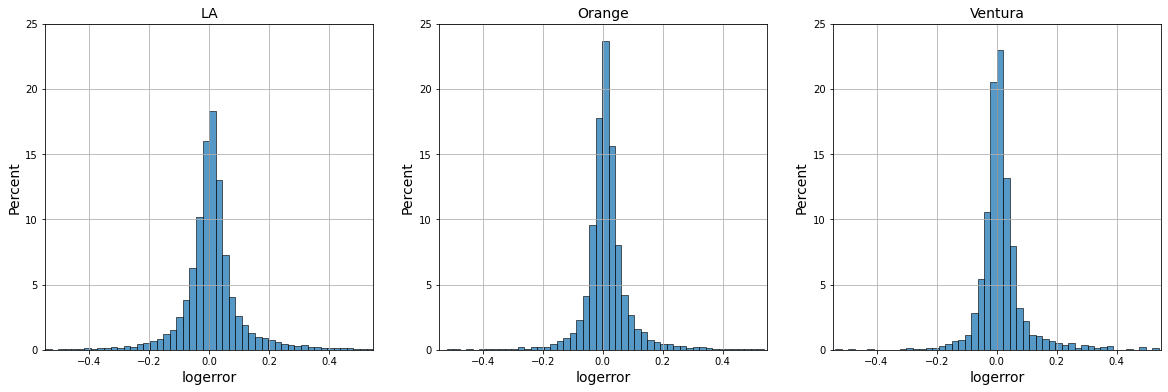

In [554]:
plt.figure(figsize=(20, 6))
for i, col in zip(range(1, 4), train.county_name.unique().tolist()):
    data = train[train['county_name'] == col]
    plt.subplot(1, 3, i)
    #data.logerror.hist(bins=10)
    sns.histplot(data=data, x='logerror', stat='percent', bins=50)
    plt.xlim(train.logerror.min(), train.logerror.max())
    plt.grid(True)
    plt.ylim(0, 25)
    plt.title(col)

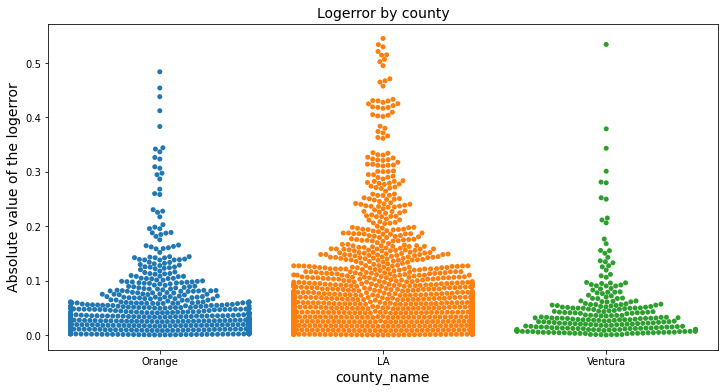

In [555]:
plt.figure(figsize=(12, 6))
plt.title('Logerror by county')
sns.swarmplot(x=sample['county_name'], y=target)
plt.ylabel('Absolute value of the logerror');

Looks that the ```logerror``` is spread in all 3 counties, LA county has the highest percentage of the error predictions and Ventura county has the best predictions with the lower ```logerror```.

Let's run the ANOVA statistical test to find out if there is a significal difference in the logerror among the counties.

In [556]:
f, p = stats.f_oneway(train[train['county_name'] == 'LA'].logerror, 
               train[train['county_name'] == 'Orange'].logerror, 
               train[train['county_name'] == 'Ventura'].logerror)
print(f'F: {round(f, 2)}, p: {round(p, 2)}')

F: 7.82, p: 0.0


The p-value is lower that our significance level. It means that there is a difference in logerrors among different counties.

##### *2. How the ```age``` of the house relates to the ```logerror```?*

In [557]:
sample.age.min(), sample.age.max()

(3, 130)

In [573]:
sample['age_bins'] = pd.cut(sample.age, bins=[0, 20, 40, 60, 80, 100, 130])
train['age_bins'] = pd.cut(train.age, bins=[0, 20, 40, 60, 80, 100, 130])

In [597]:
age_bins = []
for i in range(6):
    age_bins.append(str(sample.age_bins.value_counts().reset_index().sort_values(by='index').iloc[i, 0]))

In [579]:
bins = sample.age_bins.value_counts().reset_index().sort_values(by='index')

In [594]:
bins['index'].values

[(0, 20], (20, 40], (40, 60], (60, 80], (80, 100], (100, 130]]
Categories (6, interval[int64, right]): [(0, 20] < (20, 40] < (40, 60] < (60, 80] < (80, 100] < (100, 130]]

In [598]:
age_bins

['(0, 20]', '(20, 40]', '(40, 60]', '(60, 80]', '(80, 100]', '(100, 130]']

In [599]:
sample.age_bins = sample.age_bins.astype(str)
train.age_bins = train.age_bins.astype(str)

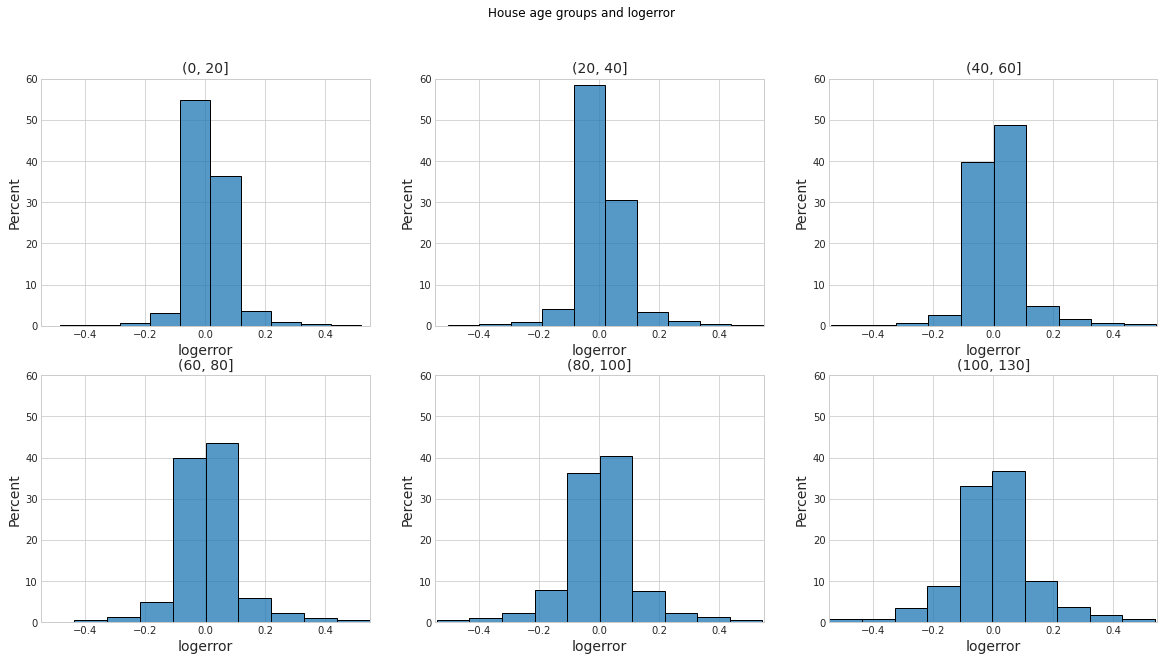

In [600]:
plt.figure(figsize=(20, 10))
plt.suptitle('House age groups and logerror')
with plt.style.context('seaborn-whitegrid'):
    for i, age in enumerate(age_bins):
        plt.subplot(2, 3, i+1)
        sns.histplot(data=train[train.age_bins==age], x='logerror', stat='percent', bins=10)
        plt.title(age)
        plt.xlim(train.logerror.min(), train.logerror.max())
        plt.ylim(0, 60)

We can see that the houses that are 20-40 years old have the best predictions, while houses after the age of 80 years have a big spread of ```logerror``` and their price is harder to predict

##### *3. Is the square footage related to the ```logerror```?*

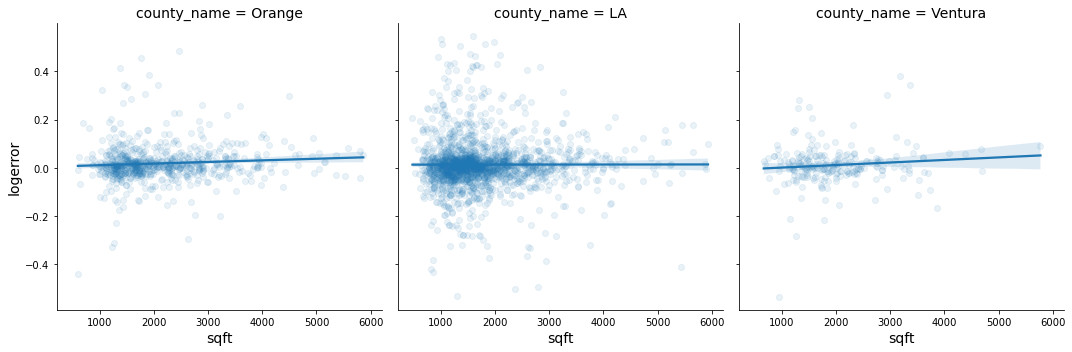

In [602]:
sns.lmplot(x='sqft', y='logerror', data=sample, 
           palette='muted', col='county_name', # hue='log_bins',
           scatter_kws = {'alpha' : 0.09} );

We can clearly see in Ventura county ```sqft``` has just a little relation to the ```logerror```.
Other counties' sq.footage ```logerror``` seems not to be related at all. I need to confirm it with the statistical test and visualization for ```sqft``` vs ```logerror```. I'm going to use Pearson R test to check if there is a the correlation  between these two variables.

In [603]:
corr, p = stats.pearsonr(train.sqft, train.logerror)
print(f'Correlation coefficient is {round(corr, 3)}')
print(f'P-value is {round(p, 2)}')

Correlation coefficient is 0.035
P-value is 0.0


Even the correlation coefficient is very low, p-value points that there is a relationship between square footage and ```logerror```.

In [604]:
for county in counties:
    print(county)
    corr, p = stats.pearsonr(counties[county].sqft, counties[county].logerror)
    print(f'Correlation coefficient is {round(corr, 3)}')
    print(f'P-value is {round(p, 2)}')
    print()

LA
Correlation coefficient is 0.025
P-value is 0.0

Orange
Correlation coefficient is 0.049
P-value is 0.0

Ventura
Correlation coefficient is 0.023
P-value is 0.28



Ventura county get less significant p-value.

##### 4. Does the number of bathrooms affect the ```logerror```?

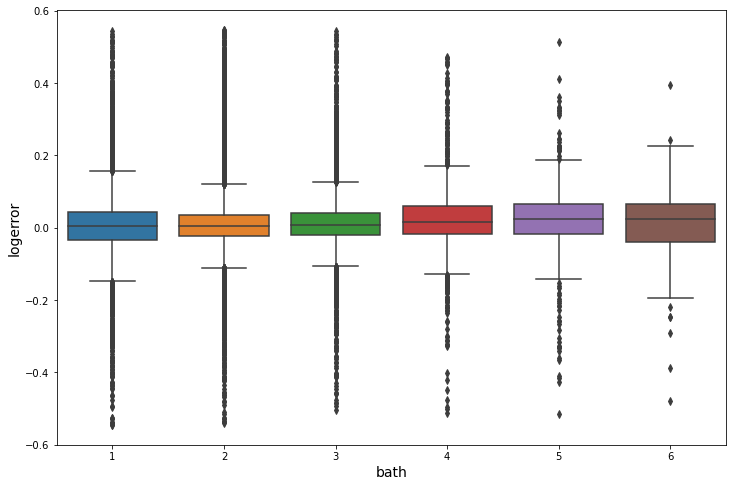

In [605]:
plt.figure(figsize=(12,8))
sns.boxplot(data=train, x='bath', y='logerror')
plt.show()

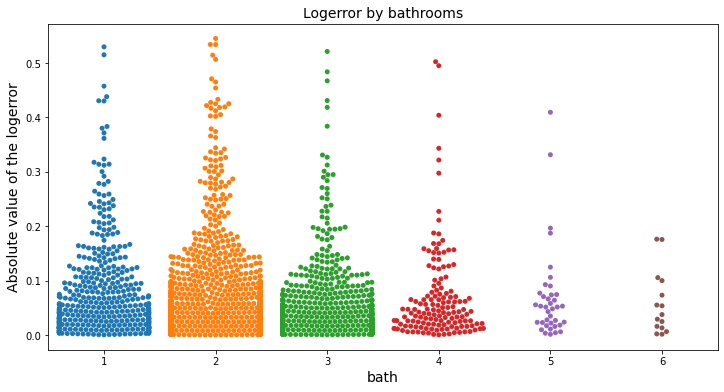

In [606]:
plt.figure(figsize=(12, 6))
plt.title('Logerror by bathrooms')
sns.swarmplot(x=sample['bath'], y=target)
plt.ylabel('Absolute value of the logerror');

Let's do the same graph county by county

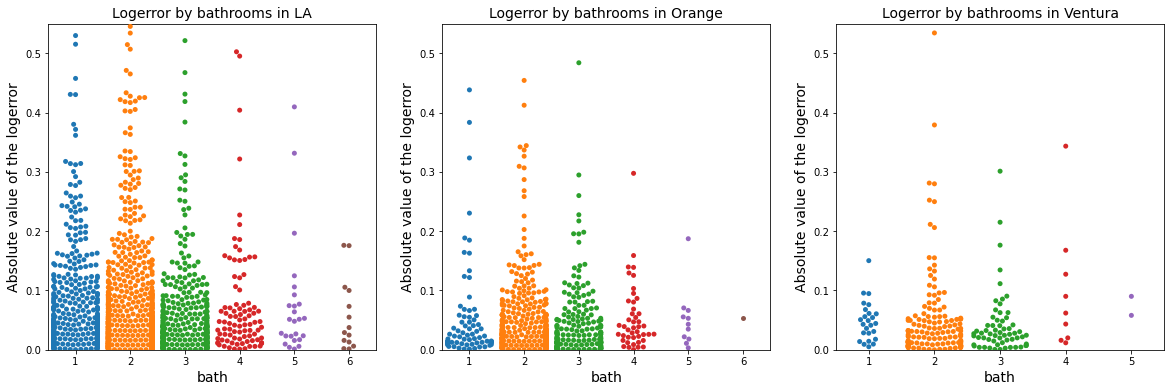

In [607]:
plt.figure(figsize=(20, 6))
for i, county in enumerate(counties):
    plt.subplot(1, 3, i+1)
    plt.title('Logerror by bathrooms in ' + county)
    sns.swarmplot(x=sample[sample.county_name == county].bath, y=target)
    plt.ylabel('Absolute value of the logerror')
    plt.ylim(0, 0.55)
plt.show()

We can see that ```logerror``` peaks ar ```bath=2``` in the regular set and LA&Ventura sets. In Orange county the ```logerror``` is relatively high in most of bathrooms

What about beds to bath ratio?

In [669]:
train.bed_bath_ratio.max()

5.0

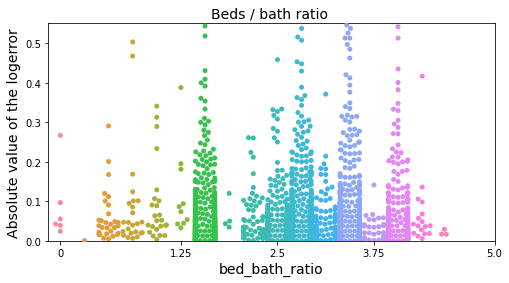

In [668]:
plt.figure(figsize=(8, 4))
plt.title('Beds / bath ratio ')
ax = sns.swarmplot(x=sample.bed_bath_ratio, y=target)
plt.ylabel('Absolute value of the logerror')
plt.ylim(0, 0.55)
ax.set(xticks=[0, 5, 9, 13, 18])
ax.set(xticklabels=[0, 1.25, 2.5, 3.75, 5.00])
plt.show()

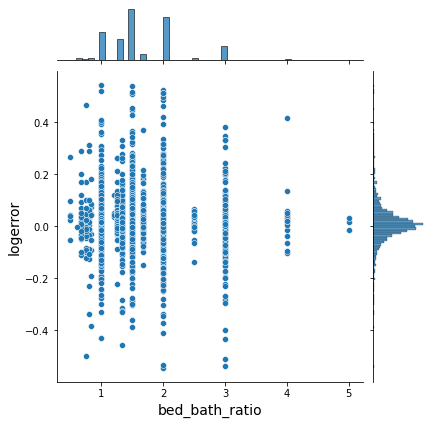

In [670]:
sns.jointplot(data=sample, x='bed_bath_ratio', y='logerror')

In [667]:
# looks like nothing interesting.
stats.kruskal(train.bed_bath_ratio, train.logerror)

KruskalResult(statistic=41900.98644090803, pvalue=0.0)

##### 5. Is the separation the data by zip code different from the separation by county?

<AxesSubplot:xlabel='zip', ylabel='logerror'>

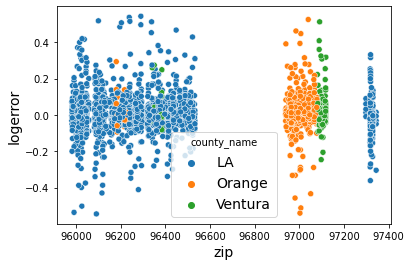

In [666]:
sns.scatterplot(data=sample, x='zip', y='logerror', hue='county_name')

In [645]:
(train.zip > 99950).sum()

3

In [633]:
sns.swarmplot(data=sample, x='county_id', y='logerror', hue='county_name')

In [ ]:
train.columns

In [634]:
df.shape

(49580, 23)

In [73]:
location = sample[['latitude', 'longitude']].copy()

In [78]:
location=pd.DataFrame(scale(location), columns = ['latitude', 'longitude'])

In [79]:
location

,latitude,longitude
0,0.582,0.336
1,0.073,0.660
2,0.428,-0.054
3,0.534,0.231
4,-0.526,-0.554
...,...,...
561,-0.803,-0.707
562,-1.166,0.611
563,-1.162,0.530
564,2.109,0.070


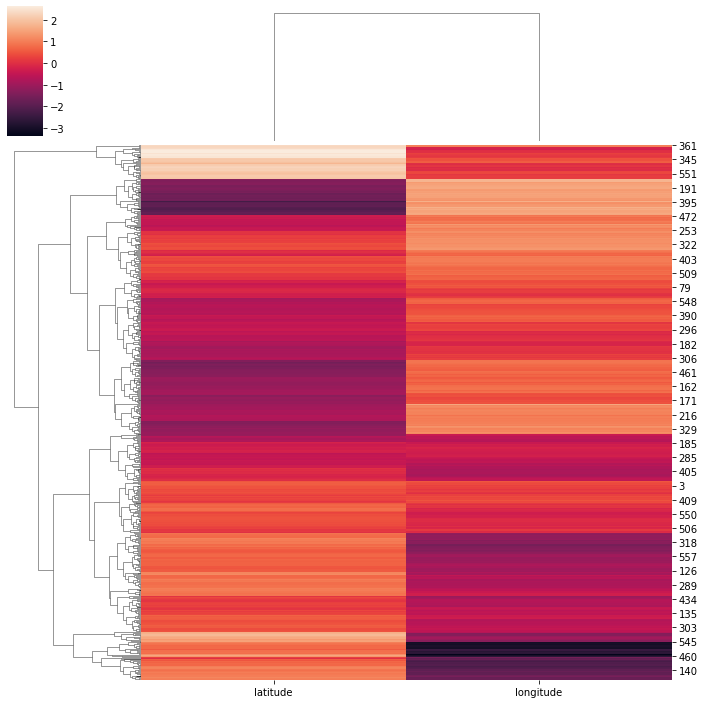

In [80]:
sns.clustermap(location)

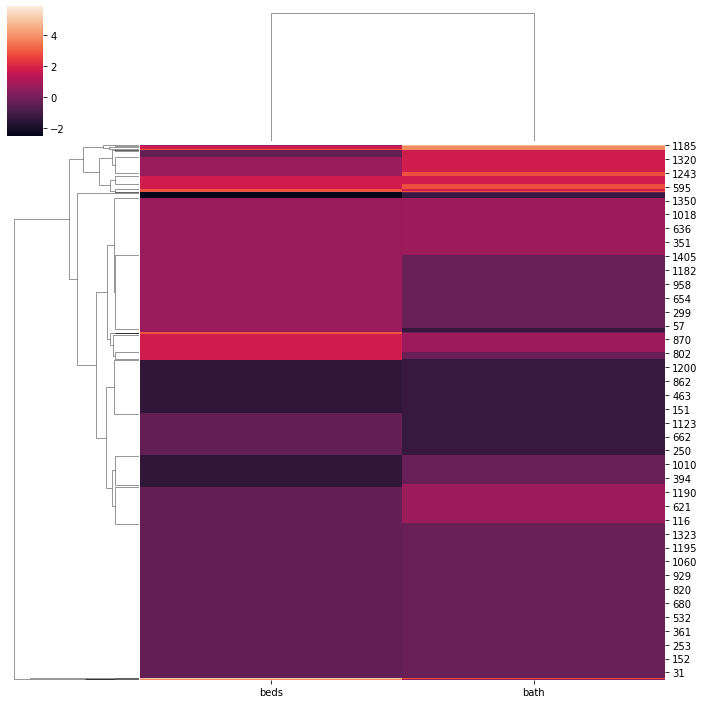

In [241]:
bed_bath = sample[['beds', 'bath']].copy()
bed_bath = pd.DataFrame(scale(bed_bath), columns = ['beds', 'bath'])
sns.clustermap(bed_bath)

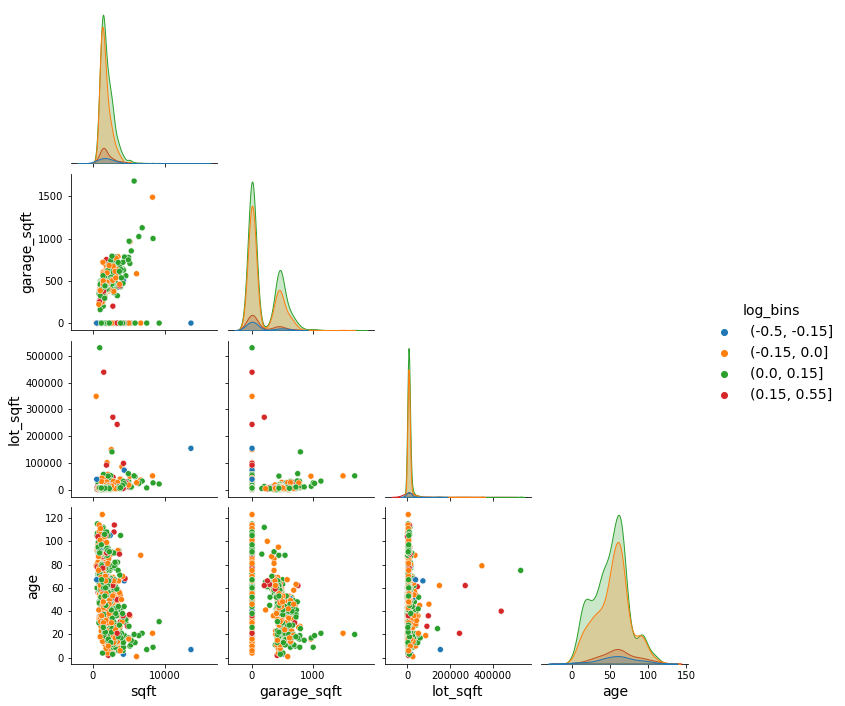

In [130]:

sns.pairplot(data=sample[['sqft','garage_sqft', 'lot_sqft', 'age', 'log_bins']], hue='log_bins', corner=True);

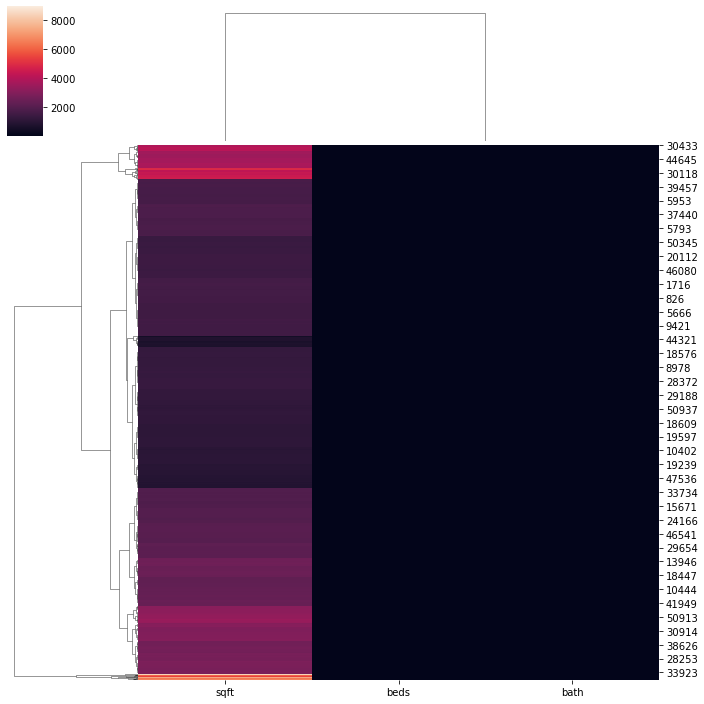

In [248]:
sqft_bath = sample[['sqft', 'beds', 'bath']].copy()
bed_bath = pd.DataFrame(scale(sqft_bath), columns = ['sqft', 'beds', 'bath'])
sns.clustermap(sqft_bath)

In [254]:
sample.columns

Index(['sqft', 'garage_sqft', 'lot_sqft', 'age', 'structure_price', 'price',
       'land_price', 'tax_amount', 'zip', 'latitude', 'longitude', 'bath',
       'beds', 'fireplace', 'garage', 'hottub_spa', 'pool', 'unit',
       'heating_system', 'county_land_code', 'county_name', 'logerror',
       'log_bins', 'abs_logerror', 'log_bins4', 'log_sqft', 'log_garage_sqft',
       'log_lot_sqft', 'log_age', 'log_structure_price', 'log_price',
       'log_land_price', 'log_tax_amount', 'age_bins'],
      dtype='object')

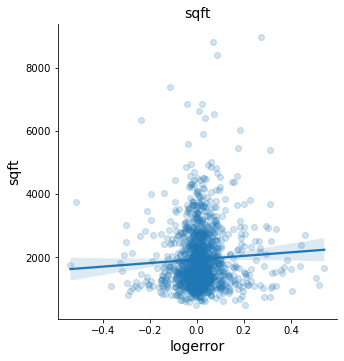

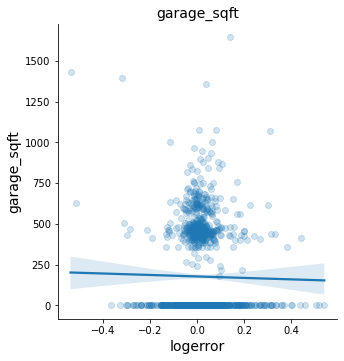

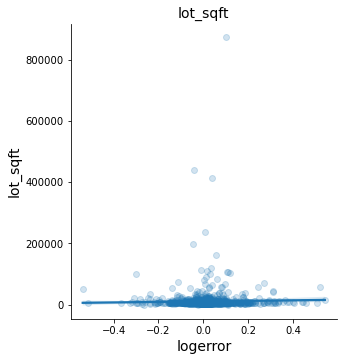

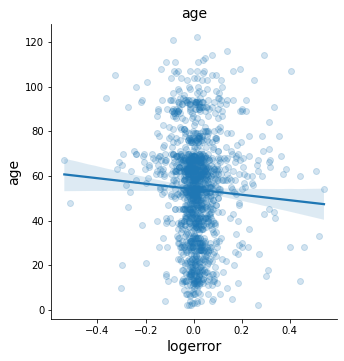

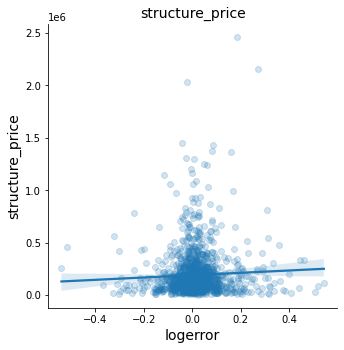

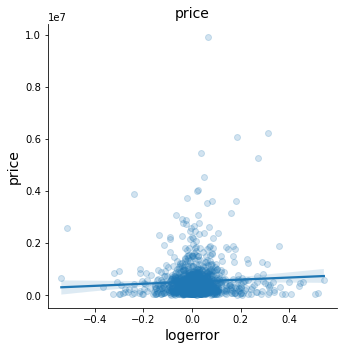

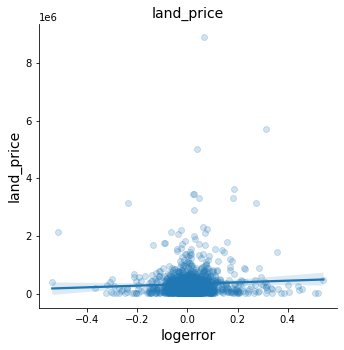

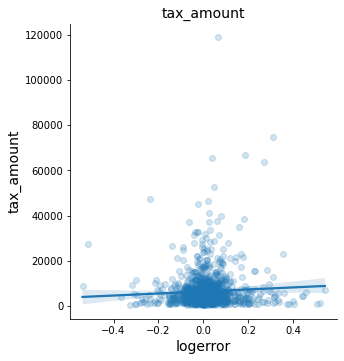

In [256]:
for value in numerical_columns:
    sns.lmplot(data=sample, x='logerror', y=value, scatter_kws = {'alpha' : 0.2})
    plt.title(value)
    plt.show()

In [268]:
sample['price_rate'] = round(sample.tax_amount / sample.price, 2)

In [269]:
sample.price_rate.max()

0.18

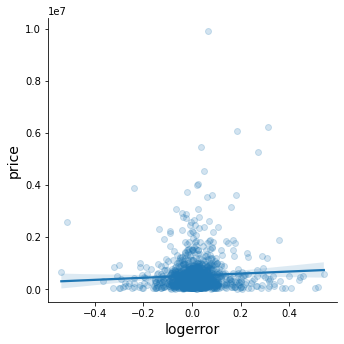

In [272]:
sns.lmplot(data=sample, x='logerror', y='price', scatter_kws = {'alpha' : 0.2})

In [271]:
df = wr.acquire_zillow()

In [277]:
vif_data = pd.DataFrame()
vif_col = numerical_columns + ['logerror']
vif_data['features'] = vif_col
vif_data['VIF'] = [variance_inflation_factor(train[vif_col].values, i) for i in range(len(vif_col))]

In [278]:
vif_data

,features,VIF
0,sqft,7.960
1,garage_sqft,1.741
2,lot_sqft,1.051
3,age,2.760
4,structure_price,inf
5,price,inf
6,land_price,inf
7,tax_amount,93.597
8,logerror,1.018
